# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [38]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = '/Users/squid504s/Desktop/GitHub/2nd-ML100Days/data/主題一/'


### 之前做過的處理

In [5]:
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)
app_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
216649,351032,0,Cash loans,F,N,N,0,81000.0,900000.0,38133.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
105502,222421,0,Cash loans,F,N,N,0,99000.0,1300500.0,38025.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
268040,410576,0,Cash loans,M,Y,N,0,135000.0,568800.0,16299.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
219700,354517,0,Cash loans,F,N,N,0,90000.0,231813.0,11965.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
30022,134852,0,Cash loans,F,Y,Y,1,202500.0,1800000.0,62698.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0


In [6]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

In [48]:
print(app_train['DAYS_BIRTH'].sample(10))
app_train['age'] = app_train['DAYS_BIRTH']/365
print('----------------------------')
print(app_train['age'].sample(5))
print('----------------------------')
print(app_train['age'].describe())

247918    17655
274896    11269
288533    10190
269188     9914
198127    15366
56423     11398
231135    15701
29489     17598
153923    13607
116930    14209
Name: DAYS_BIRTH, dtype: int64
----------------------------
287652    28.038356
48191     40.224658
161915    49.860274
212608    47.038356
296546    63.704110
Name: age, dtype: float64
----------------------------
count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: age, dtype: float64


In [53]:
# 新增欄位 "equal_width_age", 對年齡做等寬劃分
app_train["equal_width_age"] = pd.cut(app_train["age"], 4)
app_train["equal_width_age"].value_counts().sort_index()

(20.469, 32.668]     66536
(32.668, 44.819]    100808
(44.819, 56.97]      84685
(56.97, 69.121]      55482
Name: equal_width_age, dtype: int64

In [54]:
# 新增欄位 "equal_freq_age", 對年齡做等頻劃分
app_train["equal_freq_age"] = pd.qcut(app_train["age"], 4)
# 觀察等頻劃分下, 每個種組距各出現幾次
app_train["equal_freq_age"].value_counts().sort_index() # 每個 bin 的資料筆數是一樣的

(20.517, 34.008]    76884
(34.008, 43.151]    76877
(43.151, 53.923]    76887
(53.923, 69.121]    76863
Name: equal_freq_age, dtype: int64

In [58]:
app_train["customized_age_grp"] = pd.cut(app_train["age"],[20,30,40,50,60,100])
app_train["customized_age_grp"].value_counts().sort_index()

(20, 30]     45021
(30, 40]     82308
(40, 50]     76541
(50, 60]     68062
(60, 100]    35579
Name: customized_age_grp, dtype: int64

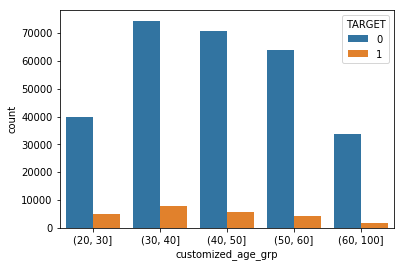

In [60]:
sns.countplot(x="customized_age_grp", hue="TARGET", data=app_train)
plt.show()

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [9]:
app_train['AMT_INCOME_TOTAL']

0         202500.000
1         270000.000
2          67500.000
3         135000.000
4         121500.000
5          99000.000
6         171000.000
7         360000.000
8         112500.000
9         135000.000
10        112500.000
11         38419.155
12         67500.000
13        225000.000
14        189000.000
15        157500.000
16        108000.000
17         81000.000
18        112500.000
19         90000.000
20        135000.000
21        202500.000
22        450000.000
23         83250.000
24        135000.000
25         90000.000
26        112500.000
27        112500.000
28        270000.000
29         90000.000
             ...    
307481    225000.000
307482    225000.000
307483     99000.000
307484    540000.000
307485    270000.000
307486    292500.000
307487    117000.000
307488    157500.000
307489    225000.000
307490     81000.000
307491     90000.000
307492    585000.000
307493    135000.000
307494    270000.000
307495    180000.000
307496    360000.000
307497    180

In [25]:
app_train['ait_q'] = pd.qcut(app_train['AMT_INCOME_TOTAL'],10)
app_train['ait_q'].value_counts().sort_index()

(25649.999, 81000.0]       33391
(81000.0, 99000.0]         30280
(99000.0, 112500.0]        36907
(112500.0, 135000.0]       48849
(135000.0, 147150.0]        4333
(147150.0, 162000.0]       31120
(162000.0, 180000.0]       30704
(180000.0, 225000.0]       44809
(225000.0, 270000.0]       19957
(270000.0, 117000000.0]    27161
Name: ait_q, dtype: int64

### 多數的客戶收入集中在50000~250000之間
### 又由100000~150000佔最多人

In [24]:
app_train['ait'] = pd.cut(app_train['AMT_INCOME_TOTAL'],[0,50000,100000,150000,200000,250000,300000,350000,400000,450000,1200000])
app_train['ait'].value_counts().sort_index()

(0, 50000]            4517
(50000, 100000]      59181
(100000, 150000]     91591
(150000, 200000]     64307
(200000, 250000]     48137
(250000, 300000]     17039
(300000, 350000]      8874
(350000, 400000]      5802
(400000, 450000]      4924
(450000, 1200000]     2981
Name: ait, dtype: int64

### AMT_INCOME_TOTAL離散化後與TARGET比例

In [36]:
def corr_2_cols(Col1, Col2):
    res = app_train.groupby([Col1, Col2]).size().unstack()
    res['per'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res


In [62]:
df = corr_2_cols('ait','TARGET')
print(df)

TARGET                 0     1       per
ait                                     
(0, 50000]          4174   343  0.075935
(50000, 100000]    54299  4882  0.082493
(100000, 150000]   83697  7894  0.086188
(150000, 200000]   58875  5432  0.084470
(200000, 250000]   44409  3728  0.077446
(250000, 300000]   15846  1193  0.070016
(300000, 350000]    8329   545  0.061415
(350000, 400000]    5462   340  0.058600
(400000, 450000]    4629   295  0.059911
(450000, 1200000]   2818   163  0.054680


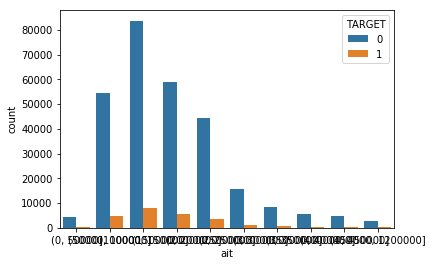

In [61]:
sns.countplot(x="ait", hue="TARGET", data=app_train)
plt.show()